
# <center> 02807 - Computational Tools for Data Science </center>  

# <center> Week 10 <center>



# <center> Today: Intro to SQL & Presentation of Project 2 <center>


* Getting started with **SQL (Structured Query Language)**.
* Most important **SQL commands** 
* Executing SQL queries in **Spark** and **Pandas**
* Presentation of **Project 2**


![SQL](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSFgnLlQINTLtDdE_QbeXARBafiEh0mhBxvgg&usqp=CAU)

# Structured Query Language

* One of the most in-demand languages for data science and analytics.
* **Standard language** for accessing and manipulating **relational databases**.
* **Relational database**: collection of **tables** (also called *relations*)
* **Table**: 
  * collection of **rows** (also called *tuples* or *records*).
  * and **columns** (also called *fields* or *attributes*).

![SQL_terms](https://www.c-sharpcorner.com/article/sql-server-and-relational-database-part-one/Images/relational%20theory.PNG)
[Source](https://www.c-sharpcorner.com/article/sql-server-and-relational-database-part-one/Images/relational%20theory.PNG)


# Pandas setup

In [ ]:
import pandas as pd
!pip install pandasql
import pandasql as psql # sql queries in pandas, uses SQLite syntax.

# Spark setup

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

# create the Spark session
conf = SparkConf().set("spark.ui.port", "4050")
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# <center> Tabular data </center>

# Hotel dataset

Week 3 flashback!
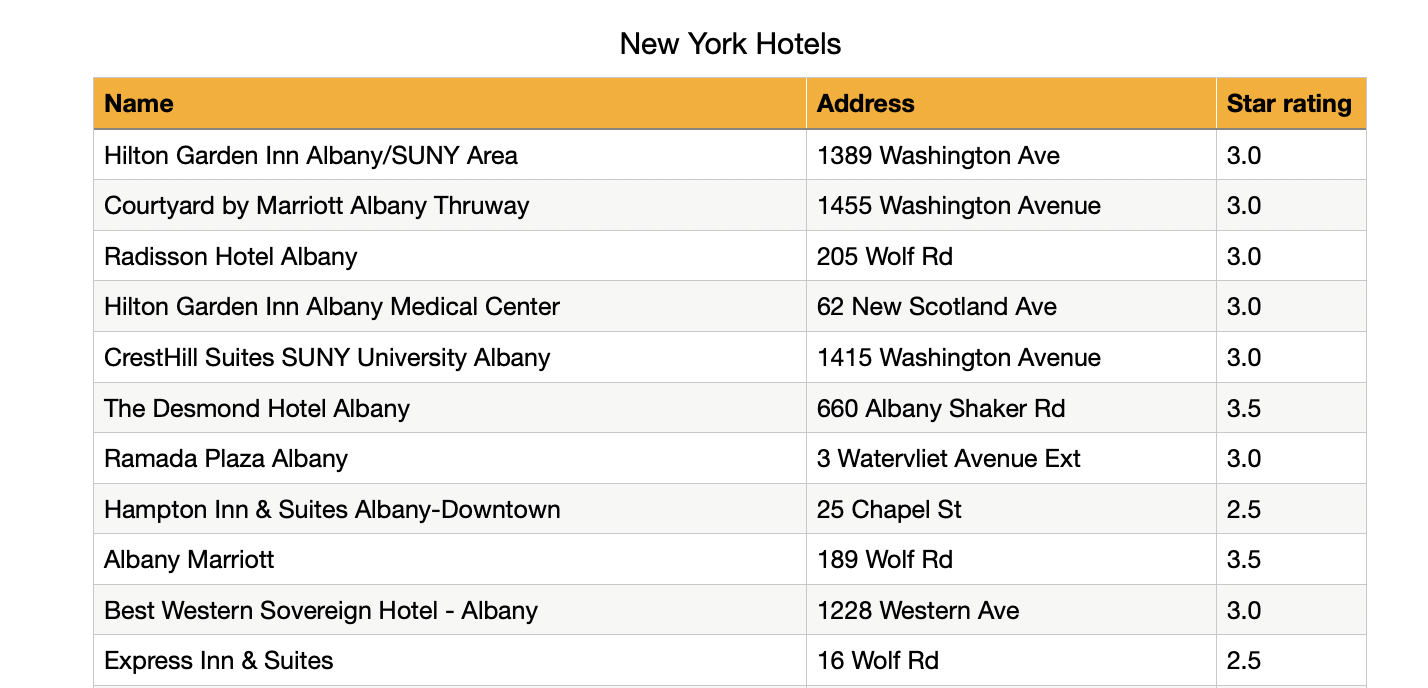

In [ ]:
from google.colab import drive
# This will prompt for authorization.

drive.mount('/content/drive')

import os
import urllib.request
hot=urllib.request.urlretrieve('https://raw.githubusercontent.com/s-heisler/pycon2017-optimizing-pandas/master/pyCon%20materials/new_york_hotels.csv','/content/sample_data/hotels.csv')

!ls '/content/sample_data'

Mounted at /content/drive
anscombe.json		      hotels.csv	     README.md
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


# Reading the data into Pandas and Spark dataframes

In [ ]:
# read the data into a pandas dataframe
hotels_pd = pd.read_csv('/content/sample_data/hotels.csv', encoding='cp1252')
hotels_sp = spark.read.option('header', True).option('inferSchema', True).csv('/content/sample_data/hotels.csv')
# to issue SQL queries using Spark SQL, we can create a temporary view of the table
hotels_sp.createOrReplaceTempView("hotels_sp")

In [ ]:
hotels_pd.head(5)

,ean_hotel_id,name,address1,city,state_province,postal_code,latitude,longitude,star_rating,high_rate,low_rate
0,269955,Hilton Garden Inn Albany/SUNY Area,1389 Washington Ave,Albany,NY,12206,42.68751,-73.81643,3.0,154.0272,124.0216
1,113431,Courtyard by Marriott Albany Thruway,1455 Washington Avenue,Albany,NY,12206,42.68971,-73.82021,3.0,179.0100,134.0000
2,108151,Radisson Hotel Albany,205 Wolf Rd,Albany,NY,12205,42.72410,-73.79822,3.0,134.1700,84.1600
3,254756,Hilton Garden Inn Albany Medical Center,62 New Scotland Ave,Albany,NY,12208,42.65157,-73.77638,3.0,308.2807,228.4597
4,198232,CrestHill Suites SUNY University Albany,1415 Washington Avenue,Albany,NY,12206,42.68873,-73.81854,3.0,169.3900,89.3900


In [ ]:
hotels_sp.toPandas().head(5)

,ean_hotel_id,name,address1,city,state_province,postal_code,latitude,longitude,star_rating,high_rate,low_rate
0,269955,Hilton Garden Inn Albany/SUNY Area,1389 Washington Ave,Albany,NY,12206,42.68751,-73.81643,3.0,154.0272,124.0216
1,113431,Courtyard by Marriott Albany Thruway,1455 Washington Avenue,Albany,NY,12206,42.68971,-73.82021,3.0,179.0100,134.0000
2,108151,Radisson Hotel Albany,205 Wolf Rd,Albany,NY,12205,42.72410,-73.79822,3.0,134.1700,84.1600
3,254756,Hilton Garden Inn Albany Medical Center,62 New Scotland Ave,Albany,NY,12208,42.65157,-73.77638,3.0,308.2807,228.4597
4,198232,CrestHill Suites SUNY University Albany,1415 Washington Avenue,Albany,NY,12206,42.68873,-73.81854,3.0,169.3900,89.3900


In [ ]:
# cache the data
# since we'll use it repeatedly
hotels_sp.cache()
hotels_sp.count()

1631

# Fundamentals of SQL Queries

## SELECT ... FROM ... WHERE

```
SELECT column1, column2, ...
FROM table_name
WHERE condition
```
![select](https://i.imgur.com/HJOT8Kb.png)

[Image source](https://www.kaggle.com/dansbecker/select-from-where)


In [ ]:
# select all rows from the hotels table
psql.sqldf("SELECT * FROM hotels_pd") # pandas

,ean_hotel_id,name,address1,city,state_province,postal_code,latitude,longitude,star_rating,high_rate,low_rate
0,269955,Hilton Garden Inn Albany/SUNY Area,1389 Washington Ave,Albany,NY,12206,42.68751,-73.81643,3.0,154.0272,124.0216
1,113431,Courtyard by Marriott Albany Thruway,1455 Washington Avenue,Albany,NY,12206,42.68971,-73.82021,3.0,179.0100,134.0000
2,108151,Radisson Hotel Albany,205 Wolf Rd,Albany,NY,12205,42.72410,-73.79822,3.0,134.1700,84.1600
3,254756,Hilton Garden Inn Albany Medical Center,62 New Scotland Ave,Albany,NY,12208,42.65157,-73.77638,3.0,308.2807,228.4597
4,198232,CrestHill Suites SUNY University Albany,1415 Washington Avenue,Albany,NY,12206,42.68873,-73.81854,3.0,169.3900,89.3900
...,...,...,...,...,...,...,...,...,...,...,...
1626,324259,Residence Inn Yonkers Westchester County,7 Executive Blvd,Yonkers,NY,10701,40.97275,-73.88075,3.0,269.3600,169.3600
1627,107949,Ramada Inn Yonkers,125 Tuckahoe Rd,Yonkers,NY,10710,40.95466,-73.86483,2.5,129.0000,119.0000
1628,509723,Hyatt Place New York/Yonkers,7000 Mall Walk,Yonkers,NY,10704,40.92625,-73.85438,3.0,249.3100,199.3100
1629,621870,Hampton Inn & Suites Yonkers - Westchester,555 Tuckahoe Rd,Yonkers,NY,10710,40.95375,-73.84935,2.5,189.1900,134.1800


In [ ]:
spark.sql("SELECT * FROM hotels_sp").toPandas()

,ean_hotel_id,name,address1,city,state_province,postal_code,latitude,longitude,star_rating,high_rate,low_rate
0,269955,Hilton Garden Inn Albany/SUNY Area,1389 Washington Ave,Albany,NY,12206,42.68751,-73.81643,3.0,154.0272,124.0216
1,113431,Courtyard by Marriott Albany Thruway,1455 Washington Avenue,Albany,NY,12206,42.68971,-73.82021,3.0,179.0100,134.0000
2,108151,Radisson Hotel Albany,205 Wolf Rd,Albany,NY,12205,42.72410,-73.79822,3.0,134.1700,84.1600
3,254756,Hilton Garden Inn Albany Medical Center,62 New Scotland Ave,Albany,NY,12208,42.65157,-73.77638,3.0,308.2807,228.4597
4,198232,CrestHill Suites SUNY University Albany,1415 Washington Avenue,Albany,NY,12206,42.68873,-73.81854,3.0,169.3900,89.3900
...,...,...,...,...,...,...,...,...,...,...,...
1626,324259,Residence Inn Yonkers Westchester County,7 Executive Blvd,Yonkers,NY,10701,40.97275,-73.88075,3.0,269.3600,169.3600
1627,107949,Ramada Inn Yonkers,125 Tuckahoe Rd,Yonkers,NY,10710,40.95466,-73.86483,2.5,129.0000,119.0000
1628,509723,Hyatt Place New York/Yonkers,7000 Mall Walk,Yonkers,NY,10704,40.92625,-73.85438,3.0,249.3100,199.3100
1629,621870,Hampton Inn & Suites Yonkers - Westchester,555 Tuckahoe Rd,Yonkers,NY,10710,40.95375,-73.84935,2.5,189.1900,134.1800


In [ ]:
# select name and city columns
query = """ 
  SELECT
    name, city
  FROM
    hotels_pd
    """
psql.sqldf(query)

,name,city
0,Hilton Garden Inn Albany/SUNY Area,Albany
1,Courtyard by Marriott Albany Thruway,Albany
2,Radisson Hotel Albany,Albany
3,Hilton Garden Inn Albany Medical Center,Albany
4,CrestHill Suites SUNY University Albany,Albany
...,...,...
1626,Residence Inn Yonkers Westchester County,Yonkers
1627,Ramada Inn Yonkers,Yonkers
1628,Hyatt Place New York/Yonkers,Yonkers
1629,Hampton Inn & Suites Yonkers - Westchester,Yonkers


In [ ]:
# Which hotels are in Albany?
albany_hotels = psql.sqldf("SELECT name, city FROM hotels_pd WHERE city='Albany'") # pandas
albany_hotels

,name,city
0,Hilton Garden Inn Albany/SUNY Area,Albany
1,Courtyard by Marriott Albany Thruway,Albany
2,Radisson Hotel Albany,Albany
3,Hilton Garden Inn Albany Medical Center,Albany
4,CrestHill Suites SUNY University Albany,Albany
5,The Desmond Hotel Albany,Albany
6,Ramada Plaza Albany,Albany
7,Hampton Inn & Suites Albany-Downtown,Albany
8,Albany Marriott,Albany
9,Best Western Sovereign Hotel - Albany,Albany


## LIMIT

In [ ]:
#  table with the first 10 rows of albany_hotels 
psql.sqldf("SELECT * FROM albany_hotels LIMIT 10")

,name,city
0,Hilton Garden Inn Albany/SUNY Area,Albany
1,Courtyard by Marriott Albany Thruway,Albany
2,Radisson Hotel Albany,Albany
3,Hilton Garden Inn Albany Medical Center,Albany
4,CrestHill Suites SUNY University Albany,Albany
5,The Desmond Hotel Albany,Albany
6,Ramada Plaza Albany,Albany
7,Hampton Inn & Suites Albany-Downtown,Albany
8,Albany Marriott,Albany
9,Best Western Sovereign Hotel - Albany,Albany


## AND, OR, and NOT

```
SELECT column1, column2, ...
FROM table_name
WHERE (condition 1 AND condition2 ) OR (NOT condition3)
```

In [ ]:
# Which hotels are in Albany 
# AND have postal code 12206 OR 12211 
# AND have more than 2.5 stars?
query = """ 
  SELECT
    name, city, postal_code, star_rating
  FROM
    hotels_pd
  WHERE 
    (city = 'Albany' AND (postal_code = 12206 OR postal_code = 12211) AND star_rating > 2.5)
    """
psql.sqldf(query)

,name,city,postal_code,star_rating
0,Hilton Garden Inn Albany/SUNY Area,Albany,12206,3.0
1,Courtyard by Marriott Albany Thruway,Albany,12206,3.0
2,CrestHill Suites SUNY University Albany,Albany,12206,3.0
3,The Desmond Hotel Albany,Albany,12211,3.5
4,Ramada Plaza Albany,Albany,12206,3.0


In [ ]:
#Equivalent spark query: same logic!
(hotels_sp
 .select('name', 'city', 'postal_code', 'star_rating')
 .where("(city = 'Albany' AND (postal_code = 12206 OR postal_code = 12211) AND star_rating > 2.5)")
).show(truncate=False)

+---------------------------------------+------+-----------+-----------+
|name                                   |city  |postal_code|star_rating|
+---------------------------------------+------+-----------+-----------+
|Hilton Garden Inn Albany/SUNY Area     |Albany|12206      |3.0        |
|Courtyard by Marriott Albany Thruway   |Albany|12206      |3.0        |
|CrestHill Suites SUNY University Albany|Albany|12206      |3.0        |
|The Desmond Hotel Albany               |Albany|12211      |3.5        |
|Ramada Plaza Albany                    |Albany|12206      |3.0        |
+---------------------------------------+------+-----------+-----------+



## ORDER BY

```
SELECT column1, column2, ...
FROM table_name
ORDER BY column1, column2, ... ASC|DESC;
```

In [ ]:
# what are the 10 most expensive hotels?
hotels_pd[['name','high_rate']].sort_values(by=['high_rate'],ascending=False).head(10)

,name,high_rate
1113,Safehouse Suites Manhattan,10888.5000
1074,The Towers of the Waldorf Astoria New York,10000.0000
901,Dream Downtown,5000.3501
1012,"The Carlyle, A Rosewood Hotel",4100.0400
1064,Four Seasons Hotel New York,4061.2090
1067,"Mandarin Oriental, New York",3993.4500
1076,"The Ritz-Carlton New York, Central Park",3495.5322
1082,The Mark,3488.4800
1062,"The Chatwal, a Luxury Collection Hotel, New Yo...",3406.3999
1050,The Plaza Hotel,3225.1599


In [ ]:
#@markdown what are the 10 most expensive hotels?
select_clause = "SELECT name, high_rate " #@param{type:"string"}
from_clause = "FROM hotels_pd " #@param{type:"string"}
orderBy_clause = "ORDER BY high_rate DESC " #@param{type:"string"}
limit_clause = "LIMIT 10" #@param{type:"string"}
q = (select_clause 
     + from_clause 
     + orderBy_clause 
     + limit_clause)

psql.sqldf(q)

,name,high_rate
0,Safehouse Suites Manhattan,10888.5000
1,The Towers of the Waldorf Astoria New York,10000.0000
2,Dream Downtown,5000.3501
3,"The Carlyle, A Rosewood Hotel",4100.0400
4,Four Seasons Hotel New York,4061.2090
5,"Mandarin Oriental, New York",3993.4500
6,"The Ritz-Carlton New York, Central Park",3495.5322
7,The Mark,3488.4800
8,"The Chatwal, a Luxury Collection Hotel, New Yo...",3406.3999
9,The Plaza Hotel,3225.1599


In [ ]:
# what are the 5 most affordable hotels with at least 3.5 stars?
hotels_short = hotels_pd[['name','star_rating','low_rate']]
hotels_short[(hotels_short.star_rating > 3.5)].sort_values(by=['low_rate']).head(5)

In [ ]:
#@markdown what are the 5 most affordable hotel with at least 3.5 stars?
select_clause = "SELECT name, star_rating, low_rate " #@param{type:"string"}
from_clause = "FROM hotels_pd " #@param{type:"string"}
where_clause = "WHERE star_rating > 3.5 " #@param{type:"string"}
orderBy_clause = "ORDER BY low_rate ASC " #@param{type:"string"}
limit_clause = "LIMIT 5" #@param{type:"string"}
q = (select_clause 
     + from_clause 
     + where_clause
     + orderBy_clause 
     + limit_clause)

psql.sqldf(q)

,name,star_rating,low_rate
0,NYLO New York City,4.0,108.9535
1,Gideon Putnam Resort And Spa,4.0,119.0000
2,Holiday Inn Manhattan-Financial District,4.0,123.9754
3,Global Luxury Apartments in White Plains,4.0,125.1500
4,Time Nyack,4.0,129.0000


Let's do some aggregations.

## COUNT, AVG, SUM, MIN, MAX

```
SELECT COUNT(column_name)
FROM table_name
WHERE condition
```

```
SELECT AVG(column_name)
FROM table_name
WHERE condition
```

etc.


In [ ]:
# What's the average star rating?
print("Pandas:")
hotels_pd['star_rating'].mean()

Pandas:


2.8947852760736197

In [ ]:
print("Spark:")
hotels_sp.select(f.avg('star_rating')).show()

Spark:
+------------------+
|  avg(star_rating)|
+------------------+
|2.8947852760736197|
+------------------+



In [ ]:
print("SQL:")
spark.sql("SELECT AVG(star_rating) FROM hotels_sp").show()

SQL:
+--------------------------------+
|avg(CAST(star_rating AS DOUBLE))|
+--------------------------------+
|              2.8947852760736197|
+--------------------------------+



In [ ]:
# What's the average low rate price in Brooklyn?
hotels_pd[hotels_pd.city == 'Brooklyn']['low_rate'].mean()

173.01858219178078

In [ ]:
brooklyn_hotels = hotels_sp.filter(f.col('city') == 'Brooklyn')
(brooklyn_hotels
 .select(f.avg('low_rate'))
 .show())

+------------------+
|     avg(low_rate)|
+------------------+
|173.01858219178078|
+------------------+



In [ ]:
query = """ 
  SELECT
    AVG(low_rate)
  FROM
    hotels_pd
  WHERE 
    city = 'Brooklyn'
    """
psql.sqldf(query)

,AVG(low_rate)
0,173.018582


## GROUP BY 

```
SELECT column_1, column_2, ...
FROM table_name
GROUP BY column_1, column_2, ...
```

GROUP_BY queries include aggregates such as `COUNT`, `MAX`, `SUM`, `AVG`.

![group](https://i.imgur.com/tqE9Eh8.png)


[Image source](https://www.kaggle.com/dansbecker/group-by-having-count)


In [ ]:
# Group the dataframe by city and postal code  
# and extract stats for price rates and star ratings
hotels_pd.groupby(['city','postal_code']).agg(
    {'star_rating': ['count', 'mean'],  # get the count and mean of star ratings
     'high_rate': ['mean','max']
    }
)

star_rating             high_rate          
                            count      mean        mean       max
city      postal_code                                            
Albany    12203                 4  2.625000  163.203600  189.1600
          12205                19  2.500000  125.023416  194.3000
          12206                 8  2.687500  142.941250  179.0800
          12207                 4  3.000000  226.954400  329.0349
          12208                 1  3.000000  308.280700  308.2807
...                           ...       ...         ...       ...
Woodstock 12498                 1  3.000000  250.205700  250.2057
Wurtsboro 12790                 1  2.000000  184.000000  184.0000
Yonkers   10701                 3  2.833333  146.129967  269.3600
          10704                 1  3.000000  249.310000  249.3100
          10710                 3  2.833333  159.396667  189.1900

[469 rows x 4 columns]

In [ ]:
q = """ 
  SELECT
    city, postal_code, 
    COUNT(star_rating), AVG(star_rating), 
    AVG(high_rate), MAX(high_rate)
  FROM
    hotels_pd
  GROUP BY city, postal_code
  ORDER BY city, postal_code
    """
psql.sqldf(q)

,city,postal_code,COUNT(star_rating),AVG(star_rating),AVG(high_rate),MAX(high_rate)
0,Albany,12203,4,2.625000,163.203600,189.1600
1,Albany,12205,19,2.500000,125.023416,194.3000
2,Albany,12206,8,2.687500,142.941250,179.0800
3,Albany,12207,4,3.000000,226.954400,329.0349
4,Albany,12208,1,3.000000,308.280700,308.2807
...,...,...,...,...,...,...
464,Woodstock,12498,1,3.000000,250.205700,250.2057
465,Wurtsboro,12790,1,2.000000,184.000000,184.0000
466,Yonkers,10701,3,2.833333,146.129967,269.3600
467,Yonkers,10704,1,3.000000,249.310000,249.3100


In [ ]:
# In Spark
(hotels_sp
 .select('city','postal_code','star_rating','high_rate')
 .groupBy('city','postal_code')
 .agg(f.count("star_rating"),
         f.avg("star_rating"),
         f.avg("high_rate"),
         f.max("high_rate")
      )
 .orderBy(["city","postal_code"], ascending=True)
 .show())

+---------+-----------+------------------+------------------+------------------+--------------+
|     city|postal_code|count(star_rating)|  avg(star_rating)|    avg(high_rate)|max(high_rate)|
+---------+-----------+------------------+------------------+------------------+--------------+
|   Albany|      12203|                 4|             2.625|          163.2036|        189.16|
|   Albany|      12205|                19|               2.5|125.02341578947366|         194.3|
|   Albany|      12206|                 8|            2.6875|         142.94125|        179.08|
|   Albany|      12207|                 4|               3.0|          226.9544|      329.0349|
|   Albany|      12208|                 1|               3.0|          308.2807|      308.2807|
|   Albany|      12209|                 1|               2.5|            139.06|        139.06|
|   Albany|      12210|                 1|               2.5|            225.47|        225.47|
|   Albany|      12211|                 

## AS

Column alias:
```
SELECT column_name AS alias_name
FROM table_name;
```
Table alias:
```
SELECT column_name(s)
FROM table_name AS alias_name;
```

In [ ]:
print("Without alias:")
spark.sql("SELECT AVG(star_rating) FROM hotels_sp").show()
print("With column alias:")
spark.sql("SELECT AVG(star_rating) as star_rating_average FROM hotels_sp").show()

Without alias:
+--------------------------------+
|avg(CAST(star_rating AS DOUBLE))|
+--------------------------------+
|              2.8947852760736197|
+--------------------------------+

With column alias:
+-------------------+
|star_rating_average|
+-------------------+
| 2.8947852760736197|
+-------------------+



## WITH ... AS

* `AS` is used in combination with `WITH` in what's called a **common table expression** (CTE).

* CTE = temporary table that you return within your query.

* CTEs helpful for splitting your queries into readable chunks, and to write queries against them.

![with1](https://i.imgur.com/0Kz8q4x.png)

![with1](https://i.imgur.com/3xQZM4p.png)



# Joins: working across tables

* Remember: database = collection of related tables
* The operations covered allow you to extract data from a single table 
* What if the data you want is spread across multiple tables?
* That's what joins are for!
* A key operation when working with relational databases




* Consider a database with two tables with informations about pets.


* ``owners`` table:
  * ``ID`` - ID number for the owner (different from the ID number for the pet)
  * ``Name`` - name of the owner
  * ``Pet_ID`` - ID number for the pet that belongs to the owner (which matches the ID number for the pet in the pets table)

* ``pets`` table:
  * ``ID`` - ID number for the pet
  * ``Name`` - name of the pet
  * ``Animal`` - type of animal

![with1](https://i.imgur.com/Rx6L4m1.png)

* Let's say that we want to relate these two tables to create a new table with just two columns: the name of the pet and the name of the owner 

* We need to match the ``ID`` column in the ``pets`` table to the ``Pet_ID`` column in the ``owners`` table.

![with1](https://i.imgur.com/eXvIORm.png)

* How? Using a ``JOIN`` **clause**



## INNER JOIN

* Select records that have matching values in both tables.

```
SELECT column_name(s)
FROM table1
INNER JOIN table2
ON table1.column_name = table2.column_name;
```


![with1](https://i.imgur.com/fLlng42.png)







Let's create a second table ``managers`` with two columns:

* `hotel`: name of a hotel 
* `manager`: the name of the hotel's manager


In [ ]:
pip install names

     |████████████████████████████████| 798kB 3.5MB/s 
  Created wheel for names: filename=names-0.3.0-cp36-none-any.whl size=803689 sha256=59530b41fc20d3ec703360365a4f3dc3f30e0e4a622956ba8ef40bc1ce728d1b
  Stored in directory: /root/.cache/pip/wheels/f9/a5/e1/be3e0aaa6fa285575078fa2aafd9959b45bdbc8de8a6803aeb
Successfully built names


In [ ]:
import names

In [ ]:
hotels_20 = hotels_pd.name.sample(20).to_frame("hotel_name")
manager = [names.get_full_name() for i in range(20)]
hotels_20['manager'] = manager
hotels_20

,hotel_name,manager
46,Buffalo Marriott Niagara,Carol Yost
186,Sleep Inn Coney Island,Christopher Eng
1421,Best Western Mountain Lake Inn,James Quero
242,Spencer Hotel,John Collins
500,Best Western Maple City Inn,Kory Bernard
890,Comfort Inn Times Square South Area,Harrison Nickles
488,Super 8 Highland NY,Nicole Burgess
445,Fairfield Inn & Suites by Marriott Geneva Fing...,Christopher Hill
565,Par Central Motor Inn,Noah James
866,"Marriott Vacation Club Pulse, New York City",Clarence Chin


Let's inner join `hotels_pd` and `hotels_20`, keeping the following fields:

* hotel name
* hotel manager
* hotel star rating



In [ ]:
q = """ 
  SELECT
    hotels_pd.name, hotels_20.manager, hotels_pd.star_rating
  FROM
    hotels_20
  INNER JOIN
    hotels_pd
  ON
    hotels_20.hotel_name = hotels_pd.name
    """
joined = psql.sqldf(q)
joined # only 20 records 

,name,manager,star_rating
0,Buffalo Marriott Niagara,Carol Yost,3.5
1,Sleep Inn Coney Island,Christopher Eng,2.0
2,Best Western Mountain Lake Inn,James Quero,2.5
3,Spencer Hotel,John Collins,2.5
4,Best Western Maple City Inn,Kory Bernard,2.5
5,Comfort Inn Times Square South Area,Harrison Nickles,3.0
6,Super 8 Highland NY,Nicole Burgess,2.0
7,Fairfield Inn & Suites by Marriott Geneva Fing...,Christopher Hill,3.0
8,Par Central Motor Inn,Noah James,1.5
9,"Marriott Vacation Club Pulse, New York City",Clarence Chin,4.0


## LEFT, RIGHT AND FULL JOINS

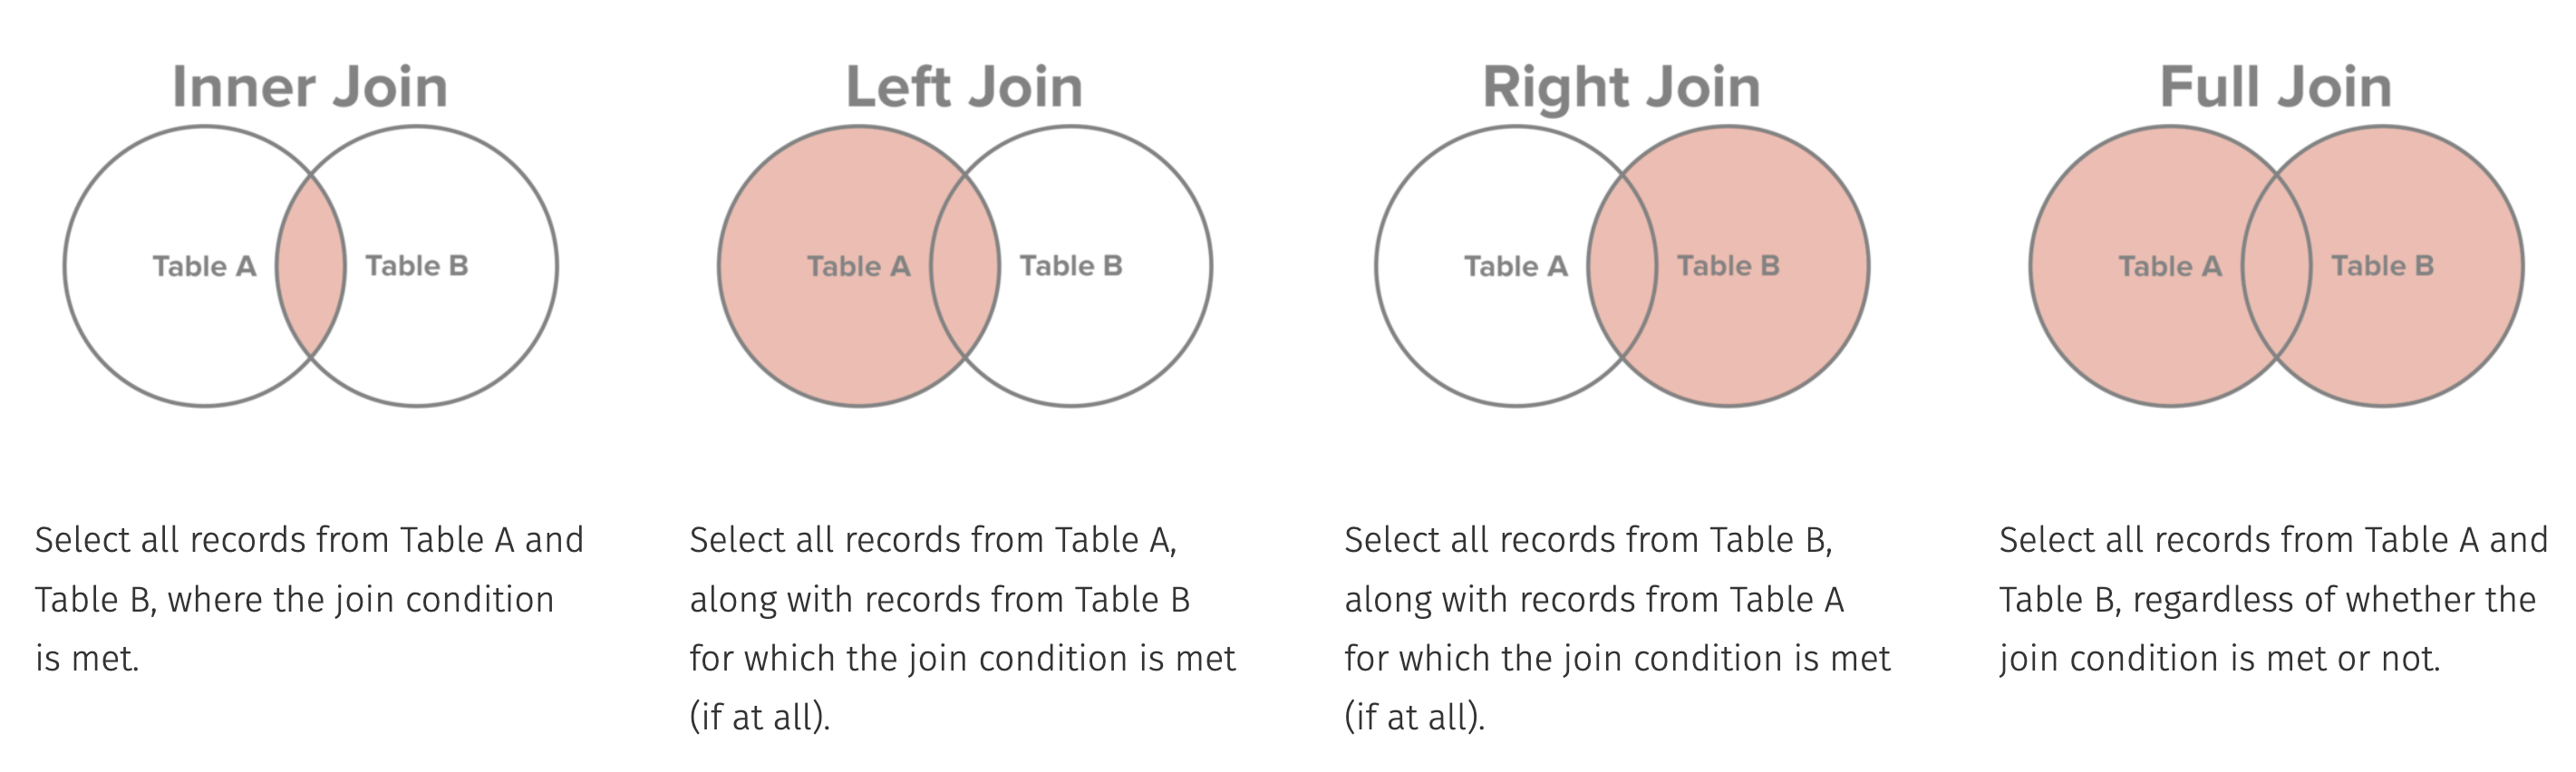

Let's look at a left join:

In [ ]:
q = """ 
  SELECT
    hotels_pd.name, hotels_20.manager, hotels_pd.star_rating
  FROM
    hotels_pd
  LEFT JOIN
    hotels_20
  ON
    hotels_20.hotel_name = hotels_pd.name
    """
joined_left = psql.sqldf(q)
joined_left # as many records as in hotels_pd

,name,manager,star_rating
0,Hilton Garden Inn Albany/SUNY Area,None,3.0
1,Courtyard by Marriott Albany Thruway,None,3.0
2,Radisson Hotel Albany,None,3.0
3,Hilton Garden Inn Albany Medical Center,None,3.0
4,CrestHill Suites SUNY University Albany,None,3.0
...,...,...,...
1626,Residence Inn Yonkers Westchester County,None,3.0
1627,Ramada Inn Yonkers,None,2.5
1628,Hyatt Place New York/Yonkers,None,3.0
1629,Hampton Inn & Suites Yonkers - Westchester,None,2.5


In [ ]:
joined_left[(joined_left.manager.notnull())] # manager values kept from hotels_20

,name,manager,star_rating
46,Buffalo Marriott Niagara,Carol Yost,3.5
99,Motel 6 Binghamton,Ronald Barrios,2.0
186,Sleep Inn Coney Island,Christopher Eng,2.0
214,Buffalo Marriott Harborcenter,Connie Deming,3.5
242,Spencer Hotel,John Collins,2.5
324,Econo Lodge DeWitt,Oscar Ross,2.0
336,Courtyard New York LaGuardia Airport,Vickie Buntin,3.0
379,Knights Inn Endwell Binghamton,Javier Korando,2.0
445,Fairfield Inn & Suites by Marriott Geneva Fing...,Christopher Hill,3.0
488,Super 8 Highland NY,Nicole Burgess,2.0


* Careful with [join duplications](https://alexpetralia.com/posts/2017/7/19/more-dangerous-subtleties-of-joins-in-sql)!